In [1]:
from Ornstein_Uhlenbeck import *
import backtrader as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
stock_list = ['SLV', 'SIL']
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/{}.csv'.format(stock), index_col='Date', parse_dates=['Date'])
columns_list = [x.lower().replace(' ', '') for x in stock_dict[stock_list[0]].columns]
date_list = stock_dict[stock_list[0]].index

In [20]:
class PandasData(bt.feeds.PandasData):
    lines = tuple(columns_list)
    params = tuple([('datetime', None)] + [(col, i) for i, col in enumerate(columns_list)])

class MyStrategy(bt.Strategy):
    def __init__(self):
        self.St = {stock_list[0]: np.array([]),
                   stock_list[1]: np.array([])
                   }
        self.model = Ornstein_Uhlenbeck(stock_dict[stock_list[0]]['Adj Close'].to_numpy()[:252], 
                                        stock_dict[stock_list[1]]['Adj Close'].to_numpy()[:252])
        self.a = 0.01
        self.signal = 0
        self.pos = 0
        self.size = 5000000
        
    def next(self):
        for data in self.datas:
            self.St[data._name] = np.append(self.St[data._name], data.adjclose[0])
        n = len(self.St[stock_list[0]])
        if n != 0 and n % 252 == 0:
            self.model = Ornstein_Uhlenbeck(self.St[stock_list[0]], self.St[stock_list[1]])

        Xt = self.model.alpha * self.St[stock_list[0]][-1] - self.model.beta * self.St[stock_list[1]][-1]
        if self.signal == 1:
            self.signal = 0 if Xt >= self.model.mu else 1
        elif self.signal == -1:
            self.signal = 0 if Xt <= self.model.mu else -1
        else:
            if Xt > np.quantile(self.model.X, 1 - self.a):
                self.signal = -1
            if Xt < np.quantile(self.model.X, self.a):
                self.signal = 1
    
        if self.signal == 1:
            if self.pos == 0:
                self.buy(data=self.datas[0], size=self.size * self.model.alpha)
                self.sell(data=self.datas[1], size=self.size * self.model.beta)
        elif self.signal == -1:
            if self.pos == 0:
                self.sell(data=self.datas[0], size=self.size * self.model.alpha)
                self.buy(data=self.datas[1], size=self.size * self.model.beta)
        elif self.signal == 0:
            if self.pos == 1:
                self.sell(data=self.datas[0], size=self.size * self.model.alpha)
                self.buy(data=self.datas[1], size=self.size * self.model.beta)
            if self.pos == -1:
                self.buy(data=self.datas[0], size=self.size * self.model.alpha)
                self.sell(data=self.datas[1], size=self.size * self.model.beta)

In [21]:
cerebro = bt.Cerebro()
data_feed_dict = {}
for stock in stock_list:
    data_feed_dict[stock] = PandasData(dataname=stock_dict[stock].iloc[252:], name=stock)
    cerebro.adddata(data_feed_dict[stock])

# Add your strategy to cerebro
cerebro.addstrategy(MyStrategy)

# Run the backtest
cerebro.broker.setcash(100000000)
cerebro.run()
cerebro.plot()

# Retrieve the performance report
performance = cerebro.runstrats[0][0]  # Get the performance report for the first strategy

# Print the key performance metrics
print("Final Portfolio Value:", performance.broker.get_value())

<IPython.core.display.Javascript object>

Final Portfolio Value: 231957883.9959197


In [69]:
slv = stock_dict['SLV']['Adj Close'].to_numpy()
sil = stock_dict['SIL']['Adj Close'].to_numpy()

In [71]:
best_alpha = None
best_capital = 0
for alpha in np.linspace(0.01, 0.5, 50):
    signal = np.zeros(len(date_list[252:]))
    for i, date in enumerate(date_list[252:]):
        if i % 252 == 0:
            m1 = Ornstein_Uhlenbeck(slv[i: i + 252], sil[i: i + 252])
        Xt = m1.alpha * slv[i + 252] - m1.beta * sil[i + 252]
        if i == 0:
            if Xt > np.quantile(m1.X, 1 - alpha):
                signal[i] = -1
            if Xt < np.quantile(m1.X, alpha):
                signal[i] = 1
        else:
            if signal[i - 1] == 1:
                if Xt >= m1.mu:
                    signal[i] = 0
                else:
                    signal[i] = 1
            elif signal[i - 1] == -1:
                if Xt <= m1.mu:
                    signal[i] = 0
                else:
                    signal[i] = -1
            else:
                if Xt > np.quantile(m1.X, 1 - alpha):
                    signal[i] = -1
                if Xt < np.quantile(m1.X, alpha):
                    signal[i] = 1
    capital = 1000000
    capital_list = np.zeros(len(date_list[252:]))
    position = 0
    price = 0
    share = 0
    
    for num, date in enumerate(date_list[252:]):
        if num % 252 == 0:
            if num != 0:
                m1 = Ornstein_Uhlenbeck(slv[num: num + 252], sil[num: num + 252])
                Xt = m1.alpha * slv[num + 252] - m1.beta * sil[num + 252]
                price = Xt
                share = capital / price
            else:
                m1 = Ornstein_Uhlenbeck(slv[num: num + 252], sil[num: num + 252])
        Xt = m1.alpha * slv[num + 252] - m1.beta * sil[num + 252]
        if position == 0:
            if signal[num] != 0:
                price = Xt
                share = capital / price
        elif position == 1:
            if signal[num] != 1:
                price = Xt
                capital = share * price
                if signal[num] == -1:
                    share = capital / price
        elif position == -1:
            if signal[num] != -1:
                capital = share * (2 * price - Xt)
                if signal[num] == 1:
                    share = capital / Xt
        position = signal[num]
    
        if position == 1:
            capital = share * Xt
        elif position == -1:
            capital = share * (2 * price - Xt)
        capital_list[num] = capital
    
        if capital <= 0:
            break
            
    if capital > best_capital:
        best_alpha = alpha
        best_capital = capital
        print(alpha, capital)

0.01 2434270.629691293
0.02 4775305.142565091
0.03 5070622.6061756965
0.05 6039091.329495349
0.060000000000000005 6168033.131713194


In [108]:
SPY = yf.download('SPY', start=start, end=end)['Adj Close']

[*********************100%%**********************]  1 of 1 completed


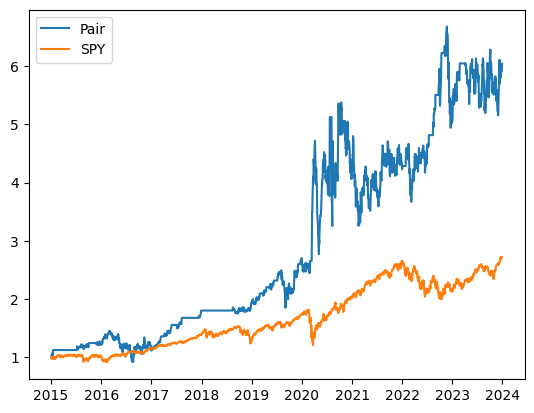

In [109]:
plt.plot(date_list[252:], capital_list / capital_list[0], label='Pair')
plt.plot(SPY.iloc[252:] / SPY.iloc[252], label='SPY')
plt.legend()